In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import sys
from impyute.imputation.cs import fast_knn

In [2]:
# import data

train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
building_meta = pd.read_csv('building_metadata.csv')
# weather_train = pd.read_csv('weather_train.csv')
# weather_test = pd.read_csv('weather_test.csv')

In [3]:
# helper functions
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def column(matrix, i):
    return [row[i] for row in matrix]

In [4]:
# peek at data contents
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
# convert categorical values to numeric labels
encoder = LabelEncoder()
bmd = building_meta
bmd.primary_use = encoder.fit_transform(bmd.primary_use)

# check for missing data
bmd.describe()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,3.409248,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,3.653530,110769.950997,31.054030,3.333683
min,0.000000,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,0.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,1.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,6.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,15.000000,875000.000000,2017.000000,26.000000


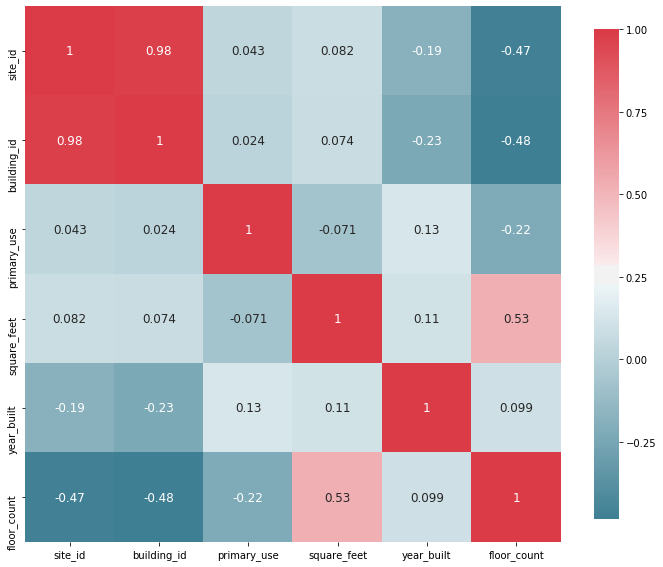

In [6]:
plot_correlation_map(bmd)

In [7]:
# https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
# https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

# for missing values impute using knn

sys.setrecursionlimit(100000)
scaler = MinMaxScaler()

floor_cnt_df = pd.concat([bmd.square_feet, bmd.floor_count], axis=1)
imputed_fc = fast_knn(floor_cnt_df.to_numpy(), k=30)
bmd.floor_count = column(imputed_fc, 1)
bmd.floor_count = bmd.floor_count.round()

yr_built_df = pd.concat([bmd.site_id, bmd.primary_use, bmd.square_feet, bmd.year_built, bmd.floor_count], axis=1)
imputed_yb = fast_knn(yr_built_df.to_numpy(), k=30)
bmd.year_built = column(imputed_yb, 3)
bmd.year_built = bmd.year_built.round()
bmd.year_built = bmd.year_built - 1900

bmd.square_feet = scaler.fit_transform(bmd.square_feet.values.reshape(-1, 1))
bmd.floor_count = scaler.fit_transform(bmd.floor_count.values.reshape(-1, 1))

bmd.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,3.0
1,0,1,0,2720,2004.0,3.0
2,0,2,0,5376,1991.0,3.0
3,0,3,0,23685,2002.0,3.0
4,0,4,0,116607,1975.0,4.0


In [8]:
bmd.to_csv( 'building_metadata_preprocessed.csv' , index = False )